In [1]:
import torch as t
import pandas as pd
# import numpy as np
# from tqdm import tqdm

from src.preprocess import *
from src.models import *
from src.utils import *

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.simplefilter('ignore')


In [2]:
# setting up
DEVICE = 'cuda' if t.cuda.is_available() else 'cpu'
DEVICE = 'mps' if t.backends.mps.is_available() else DEVICE
params = {
    'DATASET_PATH' : './dataset/result.csv',
    'LOOK_FWD' : 700,
    'W_SIZE' : 400,
    'THR' : 0.000001,
    'TRAIN_TEST_R' : 0.8,
    'TRAIN_VAL_R' : 0.8,
    'HIDDEN' : 40,
    'N_LAYERS' : 4,
    'BATCH_SIZE' : 256,
    'SAMPLES' : 5000000,
    'W_STEP' : 2
}

locals().update(params)

In [3]:
import pickle

unzip_dataset('./dataset/')
pckl_name = './dataset/dataset.pckl'
if os.path.isfile(pckl_name):
    print('loading the dataset...')
    with open(pckl_name, 'rb') as f:
        dataset_ = pickle.load(f)
else: 
    dataset_ = pd.read_csv(DATASET_PATH, index_col=0)
    print('saving the dataset...')
    with open(pckl_name, 'wb+') as f:
        pickle.dump(dataset, f)

dataset = dataset_[:SAMPLES]
dataset.shape

Dataset already extracted
loading the dataset...


(4382993, 79)

In [4]:
labels_name = './dataset/labels.pckl'
if os.path.isfile(labels_name):
    with open('./dataset/labels.pckl', 'rb') as f:
        labels = pickle.load(f)
else:
    labels = generate_labels(dataset_, LOOK_FWD, THR)
    with open('./dataset/labels.pckl', 'wb+') as f:
        pickle.dump(labels, f)
        
labels = labels[LOOK_FWD:dataset.shape[0]:W_STEP]
dataset_ = None
labels.shape

(2190797,)

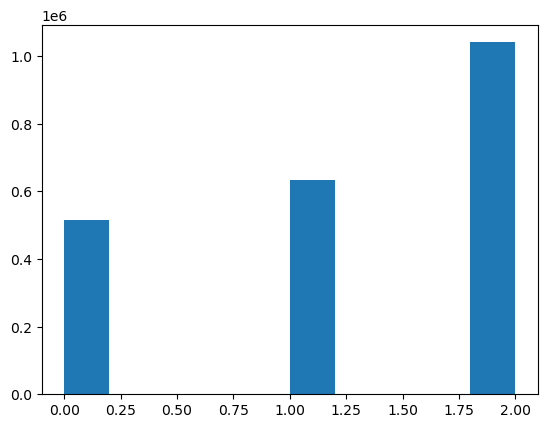

In [5]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show()

In [6]:
labels.shape

(2190797,)

In [7]:
pipe = Pipe(W_SIZE, window_step=2)

train_index = int((dataset.shape[0] - LOOK_FWD * 2 - W_SIZE) * TRAIN_TEST_R)
test_index_start = train_index + W_SIZE
ds_train = dataset[:train_index]
ds_test = dataset[test_index_start: - LOOK_FWD * 2]

dataset = None

pipe.fit(ds_train)

train_t = pipe.transform(ds_train)
test_t = pipe.transform(ds_test)

train_l_t = t.tensor(labels[:train_t.shape[0]])
test_l_t = t.tensor(labels[test_index_start // W_STEP:test_index_start // W_STEP + test_t.shape[0]])

# print(train_t.shape, train_l_t.shape)
# print(test_t.shape, test_l_t.shape)
# print(ds_train.shape, ds_test.shape)
# print(test_index_start, train_l_t.shape)

train_val_idx = int(train_l_t.shape[0] * TRAIN_VAL_R)



train_ds = t.utils.data.TensorDataset(train_t[:train_val_idx], train_l_t[:train_val_idx])
val_ds = t.utils.data.TensorDataset(train_t[train_val_idx:], train_l_t[train_val_idx:])
test_ds = t.utils.data.TensorDataset(test_t, test_l_t)

train_dl = t.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = t.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = t.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
model = Att_GRU(train_t.shape[2], 5, 20, W_SIZE, DEVICE).to(device=DEVICE)
model(train_t[500:505].to(device=DEVICE)).shape

torch.Size([5, 3])

In [9]:
model_1 = Att_GRU(test_t.shape[2],
                  n_layers=N_LAYERS,
                  hidden=HIDDEN,
                  device=DEVICE,
                  window=W_SIZE).to(device=DEVICE)
optimizer = t.optim.Adam(model.parameters(), lr=5e-4)
lf = t.nn.CrossEntropyLoss()
sm = SummaryWriter('./runs')

train(train_dl, val_dl, model, optimizer, lf, 30, device=DEVICE, sm=sm,
      save_on=5, save_params=params)
test_results = eval(test_dl, model, lf, DEVICE)
print(test_results)

train_loss: 0.958, train_acc_pre_rec: 0.566, 0.570, 0.566; || eval_loss: 0.988, eval_acc_pre_rec 0.526, 0.545, 0.526; || local_loss: 0.917:  17%|█▋        | 5/30 [18:15<1:31:09, 218.79s/it]        

model saved


train_loss: 0.955, train_acc_pre_rec: 0.570, 0.574, 0.570; || eval_loss: 0.985, eval_acc_pre_rec 0.531, 0.545, 0.531; || local_loss: 0.969:  33%|███▎      | 10/30 [36:47<1:14:32, 223.62s/it]

model saved


train_loss: 0.954, train_acc_pre_rec: 0.572, 0.576, 0.572; || eval_loss: 0.985, eval_acc_pre_rec 0.532, 0.547, 0.532; || local_loss: 0.996:  50%|█████     | 15/30 [55:33<56:16, 225.11s/it]  

model saved


train_loss: 0.953, train_acc_pre_rec: 0.573, 0.577, 0.573; || eval_loss: 0.985, eval_acc_pre_rec 0.531, 0.539, 0.531; || local_loss: 0.968:  67%|██████▋   | 20/30 [1:14:40<38:32, 231.26s/it]

model saved


train_loss: 0.952, train_acc_pre_rec: 0.574, 0.578, 0.574; || eval_loss: 0.988, eval_acc_pre_rec 0.527, 0.543, 0.527; || local_loss: 0.952:  70%|███████   | 21/30 [1:18:34<34:47, 231.97s/it]

In [ ]:
save_model(model, params, test_results, postfix='final')